ABAG Landuse Calculations

This notebook documents the joining data between VTA's TAZ Zones and 


In [49]:
#This uses geopy36
import geopandas as gpd
import pandas as pd
%matplotlib inline  
from shapely.geometry import Point

from simpledbf import Dbf5
#pip install simpledbf
#https://pypi.python.org/pypi/simpledbf/0.2.4

vta_taz = gpd.read_file('/Users/vivek/Github/VTA/Landuse/VTA_TAZ/')
vta_taz = vta_taz.rename(columns={'TAZ':'VTA_TAZ'})

dbf = Dbf5('/Users/vivek/Github/VTA/Landuse/2017ABAGLanduseAllocation/VTA/zmast13.dbf')
vta_dbf = dbf.to_dataframe()
vta_dbf = vta_dbf.rename(columns={'ZONE':'VTA_TAZ'})

vta_taz = pd.merge(vta_taz,vta_dbf)


# mtc_taz = gpd.read_file('/Users/vivek/Github/VTA/Landuse/MTC/MTCTAZ1454.dbf')


#http://analytics.mtc.ca.gov/foswiki/UrbanSimTwo/OutputToTravelModel

In [50]:
mtc_taz = gpd.read_file('/Users/vivek/Github/VTA/Landuse/MTC/')
mtc_taz = mtc_taz.rename(columns={'TAZ1454':'ZONE'})
abag_2010 = pd.read_csv('/Users/vivek/Github/VTA/Landuse/2017ABAGLanduseAllocation/ABAGPROJ2017/DRAFT/run7224c_taz_summaries_2010.csv')
mtc_taz = pd.merge(mtc_taz,abag_2010)

In [51]:
mtc_taz.head()

,AREALAND,AREAWATR,Cnty,DManParABF,DRETVTAMTC,DRetParAbg,FIPSSTCO,LANDACRE,Man_Abag10,Man_Par10,...,HHPOP,TOTPOP,EMPRES,AGE0004,AGE0519,AGE2044,AGE4564,AGE65P,total_job_spaces,total_residential_units
0,6799198,0,4,NaN,NaN,NaN,06001,1680.118487,NaN,NaN,...,2948.0,2950.0,1771.0,116.0,242.0,783.0,1277.0,532.0,3344.0,1399.0
1,659615,0,4,NaN,NaN,NaN,06001,162.994423,NaN,NaN,...,1872.0,1942.0,1202.0,89.0,173.0,812.0,653.0,215.0,6291.0,909.0
2,1074640,0,4,NaN,NaN,NaN,06001,265.549338,NaN,NaN,...,4959.0,4998.0,3260.0,264.0,415.0,2444.0,1378.0,497.0,2091.0,2595.0
3,696057,0,4,NaN,NaN,NaN,06001,171.999438,NaN,NaN,...,3606.0,3639.0,2241.0,170.0,327.0,1871.0,945.0,326.0,1434.0,1862.0
4,576343,0,4,NaN,NaN,NaN,06001,142.417463,NaN,NaN,...,3276.0,3402.0,1937.0,163.0,410.0,1669.0,777.0,383.0,898.0,1662.0


In [52]:
# vta_taz['centroid'] = vta_taz.centroid
# vta_taz = vta_taz.set_geometry('centroid')
# vta_taz['old_geometry'] = vta_taz['geometry']
# vta_taz['geometry'] = vta_taz['centroid']

# centroid = gpd.sjoin(mtc_taz[['ZONE','geometry']], vta_taz, how = "right", op='contains')
# centroid['ZONE'].nunique()
# centroid[['ZONE','VTA_TAZ']].to_csv("rel.csv")
# rel = centroid[['ZONE','VTA_TAZ']]
# missing_zones = pd.DataFrame([{'ZONE' : 1454, 'VTA_TAZ' : 2786},{'ZONE':404,'VTA_TAZ':980},{'ZONE' : 190, 'VTA_TAZ' : 1890}])
# rel = pd.concat([rel,missing_zones])
# rel.to_csv('rel.csv',index=False)

In [53]:
# vt = vta_taz.columns.values
# ab = abag_2010.columns.values 
# set(ab) - set(tz)
# # set(ab) - set(tz)
# # set(ab).difference(set(tz))
# set(vt).intersection(set(ab))
# set(ab) - set(vt)

In [54]:
rel = pd.read_csv('rel.csv')

In [55]:
rel = rel.loc[~rel['ZONE'].isnull(),]

In [57]:
len(rel)
#Should be 2576

2576

In [58]:
abag_2010.columns

Index(['zone_id', 'SD', 'ZONE', 'COUNTY', 'AGREMPN', 'FPSEMPN', 'HEREMPN',
       'RETEMPN', 'TOTEMP', 'MWTEMPN', 'OTHEMPN', 'HHINCQ1', 'HHINCQ2',
       'HHINCQ3', 'HHINCQ4', 'SHPOP62P', 'TOTHH', 'GQPOP', 'MFDU', 'SFDU',
       'CIACRE_UNWEIGHTED', 'RESACRE_UNWEIGHTED', 'CIACRE', 'RESACRE',
       'TOTACRE', 'HHPOP', 'TOTPOP', 'EMPRES', 'AGE0004', 'AGE0519', 'AGE2044',
       'AGE4564', 'AGE65P', 'total_job_spaces', 'total_residential_units'],
      dtype='object')

In [59]:
abag_2010.columns

Index(['zone_id', 'SD', 'ZONE', 'COUNTY', 'AGREMPN', 'FPSEMPN', 'HEREMPN',
       'RETEMPN', 'TOTEMP', 'MWTEMPN', 'OTHEMPN', 'HHINCQ1', 'HHINCQ2',
       'HHINCQ3', 'HHINCQ4', 'SHPOP62P', 'TOTHH', 'GQPOP', 'MFDU', 'SFDU',
       'CIACRE_UNWEIGHTED', 'RESACRE_UNWEIGHTED', 'CIACRE', 'RESACRE',
       'TOTACRE', 'HHPOP', 'TOTPOP', 'EMPRES', 'AGE0004', 'AGE0519', 'AGE2044',
       'AGE4564', 'AGE65P', 'total_job_spaces', 'total_residential_units'],
      dtype='object')

In [60]:
#Join the VTA shapefile to the abag 2010 dataset!

vt_calc = pd.merge(pd.merge(abag_2010[['ZONE','TOTHH','RESACRE','CIACRE','TOTEMP']],
                            rel,how='outer'),vta_taz[['VTA_TAZ','DIST','SDIST','CITY','COUNTY','geometry','TOTHH','TOTPOP',
                            'HHPOP','EMPRES','HH1','HH2','HH3','HH4','TACRES','RESACRE','CIACRE','TEMP',
                            'RETEMP','SEREMP','OTHEMP','AGEMP','MANEMP','WHOEMP','AGE0004','AGE0519',
                            'AGE2044','AGE4564','AGE65','SFHH','MFHH']].rename(columns={"TOTHH":"VTA_TOTHH","TOTPOP":"VTA_TOTPOP",
                            "HHPOP":"VTA_HHPOP","EMPRES":"VTA_EMPRES","RESACRE":'VTA_RESACRE',"CIACRE":"VTA_CIACRE","TEMP":"VTA_TEMP"}))

In [61]:
vt_calc.head()
# vt_calc.groupby(['ZONE','VTA_TAZ'])['VTA_TOTPOP'].apply(lambda x: x / x.sum())
# vt_calc.groupby(['ZONE','VTA_TAZ'])['VTA_TOTPOP'].sum()

,ZONE,TOTHH,RESACRE,CIACRE,TOTEMP,VTA_TAZ,DIST,SDIST,CITY,COUNTY,...,AGEMP,MANEMP,WHOEMP,AGE0004,AGE0519,AGE2044,AGE4564,AGE65,SFHH,MFHH
0,1,43.0,1.0,15.0,21892.0,1701,1,1,17,1,...,36,269,374,1,0,34,34,10,1,44
1,2,131.0,1.0,24.0,33612.0,1702,1,1,17,1,...,55,422,587,15,26,81,93,46,3,145
2,3,254.0,1.0,2.0,2003.0,1703,1,1,17,1,...,4,34,47,12,16,193,140,111,6,262
3,4,131.0,1.0,18.0,17831.0,1704,1,1,17,1,...,42,324,451,4,0,28,62,41,2,74
4,5,560.0,1.0,15.0,13388.0,1705,1,1,17,1,...,37,282,392,16,59,432,314,89,11,506


In [62]:
vt_calc[1000:1050][['ZONE','VTA_TAZ','TOTEMP','VTA_TEMP']]

,ZONE,VTA_TAZ,TOTEMP,VTA_TEMP
1000,505,14,518.0,47
1001,506,245,1927.0,85
1002,506,7,1927.0,1671
1003,506,16,1927.0,562
1004,507,229,1114.0,198
1005,507,230,1114.0,818
1006,507,18,1114.0,270
1007,508,233,1754.0,1617
1008,508,232,1754.0,992
1009,508,231,1754.0,1488


In [63]:
vt_tothh = vt_calc.groupby(['ZONE','VTA_TAZ'])['VTA_TOTHH'].sum().groupby(level = 0).transform(lambda x: x/x.sum()).reset_index()

vt_resacre = vt_calc.groupby(['ZONE','VTA_TAZ'])['VTA_RESACRE'].sum().groupby(level = 0).transform(lambda x: x/x.sum()).reset_index()
vt_ciacre = vt_calc.groupby(['ZONE','VTA_TAZ'])['VTA_CIACRE'].sum().groupby(level = 0).transform(lambda x: x/x.sum()).reset_index()
vt_temp = vt_calc.groupby(['ZONE','VTA_TAZ'])['VTA_TEMP'].sum().groupby(level = 0).transform(lambda x: x/x.sum()).reset_index()

In [64]:
vt_tothh = vt_tothh.rename(columns={"VTA_TOTHH":"VTA_TOTHH_share"})

vt_resacre = vt_resacre.rename(columns={"VTA_RESACRE":"VTA_RESACRE_share"})
vt_ciacre = vt_ciacre.rename(columns={"VTA_CIACRE":"VTA_CIACRE_share"})
vt_temp = vt_temp.rename(columns={"VTA_TEMP":"VTA_TEMP_share"})

In [65]:
vta_final= pd.merge(pd.merge(pd.merge(pd.merge(vt_calc,vt_tothh),vt_resacre),vt_ciacre),vt_temp)

In [66]:
vta_final['abag_2010_TOTHH_dist'] = round(vta_final['TOTHH']*vta_final['VTA_TOTHH_share'])

vta_final['abag_2010_RESACRE_dist'] = round(vta_final['RESACRE']*vta_final['VTA_RESACRE_share'])
vta_final['abag_2010_CIACRE_dist'] = round(vta_final['CIACRE']*vta_final['VTA_CIACRE_share'])
vta_final['abag_2010_TEMP_dist'] = round(vta_final['TOTEMP']*vta_final['VTA_TEMP_share'])

In [67]:
vta_final['abag_2010_HHPOP_dist'] = round(vta_final['VTA_HHPOP']/vta_final['VTA_TOTHH']*vta_final['abag_2010_TOTHH_dist'])

In [68]:
vta_final['abag_2010_TOTPOP_dist'] = round(vta_final['VTA_TOTPOP']/vta_final['VTA_TOTHH']*vta_final['abag_2010_TOTHH_dist'])

In [69]:
vta_final['abag_2010_EMPRES_dist'] = round(vta_final['VTA_EMPRES']/vta_final['VTA_TOTHH']*vta_final['abag_2010_TOTHH_dist'])

In [70]:
vta_final['abag_2010_HH1_dist'] = round(vta_final['HH1']/vta_final['VTA_TOTHH']*vta_final['abag_2010_TOTHH_dist'])
vta_final['abag_2010_HH2_dist'] = round(vta_final['HH2']/vta_final['VTA_TOTHH']*vta_final['abag_2010_TOTHH_dist'])
vta_final['abag_2010_HH3_dist'] = round(vta_final['HH3']/vta_final['VTA_TOTHH']*vta_final['abag_2010_TOTHH_dist'])
vta_final['abag_2010_HH4_dist'] = round(vta_final['HH4']/vta_final['VTA_TOTHH']*vta_final['abag_2010_TOTHH_dist'])


In [71]:
vta_final['abag_2010_RETEMP_dist'] = round(vta_final['RETEMP']/vta_final['VTA_TEMP']*vta_final['abag_2010_TEMP_dist'])
vta_final['abag_2010_SEREMP_dist'] = round(vta_final['SEREMP']/vta_final['VTA_TEMP']*vta_final['abag_2010_TEMP_dist'])
vta_final['abag_2010_OTHEMP_dist'] = round(vta_final['OTHEMP']/vta_final['VTA_TEMP']*vta_final['abag_2010_TEMP_dist'])
vta_final['abag_2010_AGEMP_dist'] = round(vta_final['AGEMP']/vta_final['VTA_TEMP']*vta_final['abag_2010_TEMP_dist'])
vta_final['abag_2010_MANEMP_dist'] = round(vta_final['MANEMP']/vta_final['VTA_TEMP']*vta_final['abag_2010_TEMP_dist'])
vta_final['abag_2010_WHOEMP_dist'] = round(vta_final['WHOEMP']/vta_final['VTA_TEMP']*vta_final['abag_2010_TEMP_dist'])

In [72]:
vta_final['abag_2010_AGE0004_dist'] = round(vta_final['AGE0004']/vta_final['VTA_HHPOP']*vta_final['abag_2010_HHPOP_dist'])
vta_final['abag_2010_AGE0519_dist'] = round(vta_final['AGE0519']/vta_final['VTA_HHPOP']*vta_final['abag_2010_HHPOP_dist'])
vta_final['abag_2010_AGE2044_dist'] = round(vta_final['AGE2044']/vta_final['VTA_HHPOP']*vta_final['abag_2010_HHPOP_dist'])
vta_final['abag_2010_AGE4564_dist'] = round(vta_final['AGE4564']/vta_final['VTA_HHPOP']*vta_final['abag_2010_HHPOP_dist'])
vta_final['abag_2010_AGE65_dist'] = round(vta_final['AGE65']/vta_final['VTA_HHPOP']*vta_final['abag_2010_HHPOP_dist'])

In [73]:
vta_final['abag_2010_SFHH_dist'] = round(vta_final['SFHH']/vta_final['VTA_TOTHH']*vta_final['abag_2010_TOTHH_dist'])
vta_final['abag_2010_MFHH_dist'] = round(vta_final['MFHH']/vta_final['VTA_TOTHH']*vta_final['abag_2010_TOTHH_dist'])

In [74]:
vta_final

,ZONE,TOTHH,RESACRE,CIACRE,TOTEMP,VTA_TAZ,DIST,SDIST,CITY,COUNTY,...,abag_2010_AGEMP_dist,abag_2010_MANEMP_dist,abag_2010_WHOEMP_dist,abag_2010_AGE0004_dist,abag_2010_AGE0519_dist,abag_2010_AGE2044_dist,abag_2010_AGE4564_dist,abag_2010_AGE65_dist,abag_2010_SFHH_dist,abag_2010_MFHH_dist
0,1,43.0,1.000000,15.000000,21892.0,1701,1,1,17,1,...,48.0,361.0,501.0,1.0,0.0,33.0,33.0,10.0,1.0,42.0
1,2,131.0,1.000000,24.000000,33612.0,1702,1,1,17,1,...,72.0,553.0,769.0,13.0,23.0,72.0,82.0,41.0,3.0,128.0
2,3,254.0,1.000000,2.000000,2003.0,1703,1,1,17,1,...,4.0,33.0,46.0,11.0,15.0,183.0,133.0,105.0,6.0,248.0
3,4,131.0,1.000000,18.000000,17831.0,1704,1,1,17,1,...,38.0,294.0,409.0,7.0,0.0,48.0,107.0,71.0,3.0,128.0
4,5,560.0,1.000000,15.000000,13388.0,1705,1,1,17,1,...,29.0,221.0,307.0,17.0,64.0,468.0,340.0,96.0,12.0,548.0
5,6,2162.0,7.000000,8.000000,3417.0,1706,1,1,17,1,...,3.0,24.0,10.0,48.0,456.0,2350.0,609.0,311.0,13.0,2149.0
6,7,3651.0,13.000000,14.000000,11019.0,1707,1,1,17,1,...,2.0,349.0,244.0,121.0,458.0,2640.0,1737.0,843.0,7.0,3644.0
7,8,4463.0,8.330422,15.000000,3949.0,1708,1,1,17,1,...,2.0,52.0,41.0,308.0,698.0,2888.0,3709.0,1796.0,17.0,4446.0
8,9,4932.0,9.275070,47.000000,25650.0,1709,1,1,17,1,...,3.0,733.0,415.0,338.0,862.0,4195.0,2511.0,1104.0,31.0,4901.0
9,10,3207.0,9.342438,35.000000,9072.0,1710,1,1,17,1,...,1.0,482.0,241.0,260.0,573.0,2679.0,1717.0,441.0,77.0,3130.0


In [48]:
vta_final.columns

Index(['ZONE', 'TOTHH', 'RESACRE', 'CIACRE', 'TOTEMP', 'VTA_TAZ', 'DIST',
       'SDIST', 'CITY', 'COUNTY', 'VTA_TOTHH', 'VTA_TOTPOP', 'VTA_HHPOP',
       'VTA_EMPRES', 'HH1', 'HH2', 'HH3', 'HH4', 'TACRES', 'VTA_RESACRE',
       'VTA_CIACRE', 'VTA_TEMP', 'RETEMP', 'SEREMP', 'OTHEMP', 'AGEMP',
       'MANEMP', 'WHOEMP', 'AGE0004', 'AGE0519', 'AGE2044', 'AGE4564', 'AGE65',
       'SFHH', 'MFHH', 'VTA_TOTHH_share', 'VTA_RESACRE_share',
       'VTA_CIACRE_share', 'VTA_TEMP_share', 'abag_2010_TOTHH_dist',
       'abag_2010_RESACRE_dist', 'abag_2010_CIACRE_dist',
       'abag_2010_TEMP_dist', 'abag_2010_HHPOP_dist', 'abag_2010_TOTPOP_dist',
       'abag_2010_EMPRES_dist', 'abag_2010_HH1_dist', 'abag_2010_HH2_dist',
       'abag_2010_HH3_dist', 'abag_2010_HH4_dist', 'abag_2010_RETEMP_dist',
       'abag_2010_SEREMP_dist', 'abag_2010_OTHEMP_dist',
       'abag_2010_AGEMP_dist', 'abag_2010_MANEMP_dist',
       'abag_2010_WHOEMP_dist', 'abag_2010_AGE0004_dist',
       'abag_2010_AGE0519_dist', '

ValueError: Cannot convert <shapely.geometry.polygon.Polygon object at 0x118ab1e48> to Excel

In [80]:
geometry = vta_final['geometry']
crs = mtc_taz.crs
geo_df = gpd.GeoDataFrame(vta_final, crs=crs, geometry=geometry)

In [81]:
geo_df.head()
geo_df.to_file('abag_2010_vta_dist')

In [82]:
del vta_final['geometry']
vta_final.to_csv('vta_final_abag_2010.csv',index=False)
vta_final.to_excel('vta_final_abag_2010.xlsx',index=False)

In [6]:
vta_taz.columns

Index(['Area', 'KEY', 'VTA_TAZ', 'geometry', 'DIST', 'SDIST', 'COUNTY', 'CITY',
       'TOTHH', 'HHPOP', 'TOTPOP', 'EMPRES', 'SFHH', 'MFHH', 'HH1', 'HH2',
       'HH3', 'HH4', 'INC1', 'INC2', 'INC3', 'INC4', 'MHHINC', 'TACRES',
       'RESACRE', 'CIACRE', 'Z2SHARE', 'TEMP', 'RETEMP', 'SEREMP', 'OTHEMP',
       'AGEMP', 'MANEMP', 'WHOEMP', 'AGE0004', 'AGE0519', 'AGE2044', 'AGE4564',
       'AGE65', 'AGE0513', 'AGE1417', 'AGE1824', 'ESENR', 'HSENR', 'COLLENR',
       'COLLENRF', 'COLLENRP'],
      dtype='object')

In [79]:
mtc_taz.crs

{'datum': 'NAD83',
 'lat_0': 36.5,
 'lat_1': 37.06666666666667,
 'lat_2': 38.43333333333333,
 'lon_0': -120.5,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'us-ft',
 'x_0': 2000000,
 'y_0': 500000.0000000001}

In [12]:
sccounty = vta_taz.loc[vta_taz['COUNTY'] == 3,]

In [16]:
sccounty.to_file('sccounty_shp')

In [78]:
sccounty.crs

NameError: name 'sccounty' is not defined

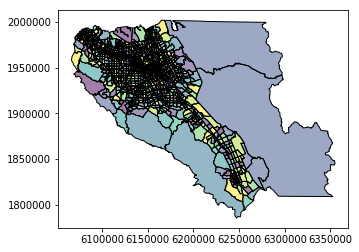

In [17]:
sccounty.plot()

In [19]:
sccounty = sccounty.to_crs({'init':'epsg:4326'})

In [20]:
sccounty

{'init': 'epsg:4326'}

In [21]:
sccounty.to_file('sccounty_4326')

In [40]:
vta_final.columns

Index(['ZONE', 'TOTHH', 'RESACRE', 'CIACRE', 'TOTEMP', 'index_right',
       'VTA_TAZ', 'DIST', 'SDIST', 'CITY', 'COUNTY', 'VTA_TOTHH', 'VTA_TOTPOP',
       'VTA_HHPOP', 'VTA_EMPRES', 'HH1', 'HH2', 'HH3', 'HH4', 'TACRES',
       'VTA_RESACRE', 'VTA_CIACRE', 'VTA_TEMP', 'RETEMP', 'SEREMP', 'OTHEMP',
       'AGEMP', 'MANEMP', 'WHOEMP', 'AGE0004', 'AGE0519', 'AGE2044', 'AGE4564',
       'AGE65', 'SFHH', 'MFHH', 'VTA_TOTHH_share', 'VTA_RESACRE_share',
       'VTA_CIACRE_share', 'VTA_TEMP_share', 'abag_2010_TOTHH_dist',
       'abag_2010_RESACRE_dist', 'abag_2010_CIACRE_dist',
       'abag_2010_TEMP_dist', 'abag_2010_HHPOP_dist', 'abag_2010_TOTPOP_dist',
       'abag_2010_EMPRES_dist', 'abag_2010_HH1_dist', 'abag_2010_HH2_dist',
       'abag_2010_HH3_dist', 'abag_2010_HH4_dist', 'abag_2010_RETEMP_dist',
       'abag_2010_SEREMP_dist', 'abag_2010_OTHEMP_dist',
       'abag_2010_AGEMP_dist', 'abag_2010_MANEMP_dist',
       'abag_2010_WHOEMP_dist', 'abag_2010_AGE0004_dist',
       'abag_2010_A

In [38]:
mtc_taz

,AREALAND,AREAWATR,Cnty,DManParABF,DRETVTAMTC,DRetParAbg,FIPSSTCO,LANDACRE,Man_Abag10,Man_Par10,...,HHPOP,TOTPOP,EMPRES,AGE0004,AGE0519,AGE2044,AGE4564,AGE65P,total_job_spaces,total_residential_units
0,6799198,0,4,NaN,NaN,NaN,06001,1680.118487,NaN,NaN,...,2948.0,2950.0,1771.0,116.0,242.0,783.0,1277.0,532.0,3344.0,1399.0
1,659615,0,4,NaN,NaN,NaN,06001,162.994423,NaN,NaN,...,1872.0,1942.0,1202.0,89.0,173.0,812.0,653.0,215.0,6291.0,909.0
2,1074640,0,4,NaN,NaN,NaN,06001,265.549338,NaN,NaN,...,4959.0,4998.0,3260.0,264.0,415.0,2444.0,1378.0,497.0,2091.0,2595.0
3,696057,0,4,NaN,NaN,NaN,06001,171.999438,NaN,NaN,...,3606.0,3639.0,2241.0,170.0,327.0,1871.0,945.0,326.0,1434.0,1862.0
4,576343,0,4,NaN,NaN,NaN,06001,142.417463,NaN,NaN,...,3276.0,3402.0,1937.0,163.0,410.0,1669.0,777.0,383.0,898.0,1662.0
5,315297,0,4,NaN,NaN,NaN,06001,77.911589,NaN,NaN,...,1738.0,1744.0,931.0,64.0,304.0,719.0,420.0,237.0,201.0,757.0
6,852890,0,4,NaN,NaN,NaN,06001,210.753718,NaN,NaN,...,4141.0,4308.0,2037.0,230.0,748.0,1599.0,1049.0,682.0,1010.0,1929.0
7,726605,0,4,NaN,NaN,NaN,06001,179.548013,NaN,NaN,...,3577.0,3731.0,1746.0,190.0,659.0,1426.0,1002.0,454.0,1040.0,1715.0
8,431231,0,4,NaN,NaN,NaN,06001,106.559505,NaN,NaN,...,2388.0,2390.0,1123.0,137.0,404.0,891.0,663.0,295.0,312.0,1155.0
9,1166661,0,4,NaN,NaN,NaN,06001,288.288224,NaN,NaN,...,5948.0,5971.0,2446.0,390.0,1257.0,2198.0,1421.0,705.0,5011.0,2661.0


In [41]:
659+463+150

1272

In [42]:
659/(659+463+150)

0.5180817610062893